In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Let's read in the census person dataset - pppub19.csv
ppdf = pd.read_csv('../data/pppub19_updated.csv')
ppdf.head()

,PERIDNUM,GESTCEN,PH_SEQ,GTCBSA,P_SEQ,A_LINENO,PF_SEQ,PHF_SEQ,OED_TYP1,OED_TYP2,...,I_DISVL1,I_DISVL2,I_SURVL1,I_SURVL2,MIG_CBST,MIG_DSCP,DEP_STAT,FILEDATE,FILESTAT,MMYY
0,1.000690e+20,11,4,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,110419,5,32019
1,3.999400e+21,11,6,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,110419,5,32019
2,9.119340e+21,11,7,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,110419,5,32019
3,1.410320e+21,11,8,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,110419,6,32019
4,1.410320e+21,11,8,0,2,2,1,1,0,0,...,0,0,0,0,0,0,0,110419,5,32019


In [3]:
#Let's start by limiting what columns we're working with
ppdf_filtered = ppdf[['PERIDNUM', 'GTCBSA', 'A_AGE', 'PTOTVAL']]
ppdf_filtered

,PERIDNUM,GTCBSA,A_AGE,PTOTVAL
0,1.000690e+20,0,21,18000
1,3.999400e+21,0,85,21780
2,9.119340e+21,0,61,12000
3,1.410320e+21,0,73,10727
4,1.410320e+21,0,37,12000
...,...,...,...,...
180096,5.977500e+21,46520,45,30001
180097,5.977500e+21,46520,15,0
180098,5.977500e+21,46520,14,0
180099,5.789400e+21,46520,57,15000


In [4]:
#Then we can narrow it down to the Nashville-Davidson-Murfreesboro-Franklin CBSA - 34980
#CBSA sourced from https://www.uspto.gov/web/offices/ac/ido/oeip/taf/cls_cbsa/cbsa_countyassoc.htm
ppdf_filtered = ppdf_filtered.loc[ppdf_filtered['GTCBSA'] == 34980]
ppdf_filtered

,PERIDNUM,GTCBSA,A_AGE,PTOTVAL
98989,7.806710e+20,34980,71,9600
98990,7.649700e+21,34980,33,33552
98991,7.649700e+21,34980,31,204695
98992,1.164640e+21,34980,58,35610
98993,7.925700e+21,34980,80,49586
...,...,...,...,...
100000,1.206770e+20,34980,31,66000
100001,1.206770e+20,34980,12,0
100002,7.602500e+21,34980,34,87650
100003,7.602500e+21,34980,31,60050


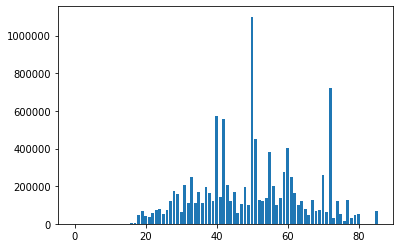

In [5]:
#Okay save this bar for later, we need to aggregate some fields first 
plt.bar('A_AGE', 'PTOTVAL', data = ppdf_filtered)
plt.show()

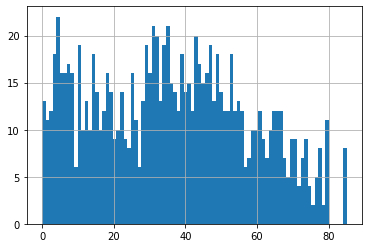

In [6]:
#Let's take a look at how many data points are in each age value
ppdf_filtered['A_AGE'].hist(bins=86)

In [7]:
ppdf_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 98989 to 100004
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PERIDNUM  1016 non-null   float64
 1   GTCBSA    1016 non-null   int64  
 2   A_AGE     1016 non-null   int64  
 3   PTOTVAL   1016 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 39.7 KB


In [8]:
#Let's aggregate things by age so we can work with them further
income_by_age = ppdf_filtered.groupby(by=['A_AGE']).agg({'PTOTVAL':['median']})
income_by_age

,PTOTVAL
,median
A_AGE,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
77,40921.0
78,18450.0


In [9]:
#Clean it up so the structure is a traditional dataframe
income_by_age.columns = income_by_age.columns.droplevel(1)
income_by_age = income_by_age.reset_index()
income_by_age

,A_AGE,PTOTVAL
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
77,77,40921.0
78,78,18450.0
79,79,25687.5
80,80,16020.0


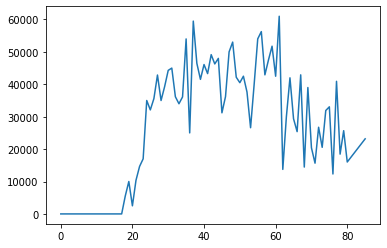

In [10]:
#Now we can plot our new dataframe
plt.plot('A_AGE', 'PTOTVAL', data = income_by_age)
plt.show()

While this is helpful for seeing some of the total income trends, some of this variance is going to cause some trouble. Binning our age groups into 5 year sections might accurately represent potential incomes. 

In [11]:
#First we'll establish our 5 year bins
age_brackets = pd.interval_range(start=15, freq=5, end=90, closed='left')
age_brackets

IntervalIndex([[15, 20), [20, 25), [25, 30), [30, 35), [35, 40) ... [65, 70), [70, 75), [75, 80), [80, 85), [85, 90)],
              closed='left',
              dtype='interval[int64]')

I have commented out the below cell because I was getting a SettingWithCopyWarning by trying to modify a df slice. The code following the below cell tests a different approach and then re-iterates the work. 

In [12]:
#Then we can apply it to our existing df
#ppdf_filtered['AGE_BRACKET'] = pd.cut(ppdf_filtered['A_AGE'], bins=age_brackets)
#ppdf_filtered

In [13]:
#Add the additional column to the original df
ppdf['AGE_BRACKET'] = pd.cut(ppdf['A_AGE'], bins=age_brackets)
ppdf

,PERIDNUM,GESTCEN,PH_SEQ,GTCBSA,P_SEQ,A_LINENO,PF_SEQ,PHF_SEQ,OED_TYP1,OED_TYP2,...,I_DISVL2,I_SURVL1,I_SURVL2,MIG_CBST,MIG_DSCP,DEP_STAT,FILEDATE,FILESTAT,MMYY,AGE_BRACKET
0,1.000690e+20,11,4,0,1,1,1,1,0,0,...,0,0,0,0,0,0,110419,5,32019,"[20.0, 25.0)"
1,3.999400e+21,11,6,0,1,1,1,1,0,0,...,0,0,0,0,0,0,110419,5,32019,"[85.0, 90.0)"
2,9.119340e+21,11,7,0,1,1,1,1,0,0,...,0,0,0,0,0,0,110419,5,32019,"[60.0, 65.0)"
3,1.410320e+21,11,8,0,1,1,1,1,0,0,...,0,0,0,0,0,0,110419,6,32019,"[70.0, 75.0)"
4,1.410320e+21,11,8,0,2,2,1,1,0,0,...,0,0,0,0,0,0,110419,5,32019,"[35.0, 40.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180096,5.977500e+21,95,94632,46520,4,4,1,2,0,0,...,0,0,0,0,0,0,110419,1,32019,"[45.0, 50.0)"
180097,5.977500e+21,95,94632,46520,5,5,1,2,0,0,...,0,0,0,0,0,3,110419,6,32019,"[15.0, 20.0)"
180098,5.977500e+21,95,94632,46520,6,6,1,2,0,0,...,0,0,0,0,0,3,110419,6,32019,NaN
180099,5.789400e+21,95,94633,46520,1,1,1,1,0,0,...,0,0,0,0,0,0,110419,5,32019,"[55.0, 60.0)"


In [14]:
#Create a copy of the DF only containing the columns we want to see
ppdf_new = ppdf[['PERIDNUM', 'GTCBSA', 'A_AGE', 'PTOTVAL', 'AGE_BRACKET']].copy()
ppdf_new.head()

,PERIDNUM,GTCBSA,A_AGE,PTOTVAL,AGE_BRACKET
0,1.000690e+20,0,21,18000,"[20, 25)"
1,3.999400e+21,0,85,21780,"[85, 90)"
2,9.119340e+21,0,61,12000,"[60, 65)"
3,1.410320e+21,0,73,10727,"[70, 75)"
4,1.410320e+21,0,37,12000,"[35, 40)"


In [15]:
#Clean up the formatting of the Age Brackets
ppdf_new['AGE_BRACKET'] = ppdf_new['AGE_BRACKET'].astype(str).str.replace('[','')
ppdf_new['AGE_BRACKET'] = ppdf_new['AGE_BRACKET'].astype(str).str.replace(')','')
ppdf_new['AGE_BRACKET'] = ppdf_new['AGE_BRACKET'].astype(str).str.replace(',',' -')
ppdf_new

,PERIDNUM,GTCBSA,A_AGE,PTOTVAL,AGE_BRACKET
0,1.000690e+20,0,21,18000,20.0 - 25.0
1,3.999400e+21,0,85,21780,85.0 - 90.0
2,9.119340e+21,0,61,12000,60.0 - 65.0
3,1.410320e+21,0,73,10727,70.0 - 75.0
4,1.410320e+21,0,37,12000,35.0 - 40.0
...,...,...,...,...,...
180096,5.977500e+21,46520,45,30001,45.0 - 50.0
180097,5.977500e+21,46520,15,0,15.0 - 20.0
180098,5.977500e+21,46520,14,0,nan
180099,5.789400e+21,46520,57,15000,55.0 - 60.0


In [16]:
#Filtering down to Nashville CBSA
ppdf_new = ppdf_new.loc[ppdf_new['GTCBSA'] == 34980]
ppdf_new

,PERIDNUM,GTCBSA,A_AGE,PTOTVAL,AGE_BRACKET
98989,7.806710e+20,34980,71,9600,70.0 - 75.0
98990,7.649700e+21,34980,33,33552,30.0 - 35.0
98991,7.649700e+21,34980,31,204695,30.0 - 35.0
98992,1.164640e+21,34980,58,35610,55.0 - 60.0
98993,7.925700e+21,34980,80,49586,80.0 - 85.0
...,...,...,...,...,...
100000,1.206770e+20,34980,31,66000,30.0 - 35.0
100001,1.206770e+20,34980,12,0,nan
100002,7.602500e+21,34980,34,87650,30.0 - 35.0
100003,7.602500e+21,34980,31,60050,30.0 - 35.0


In [17]:
#Now we can aggregate and clean up the result again
income_by_age_bracket = round(ppdf_new.groupby(by=['AGE_BRACKET']).agg({'PTOTVAL':['median']}), 2)
income_by_age_bracket.columns = income_by_age_bracket.columns.droplevel(1)
income_by_age_bracket = income_by_age_bracket.reset_index()
income_by_age_bracket

,AGE_BRACKET,PTOTVAL
0,15.0 - 20.0,0.0
1,20.0 - 25.0,15250.0
2,25.0 - 30.0,35020.0
3,30.0 - 35.0,38000.0
4,35.0 - 40.0,50259.0
5,40.0 - 45.0,47510.5
6,45.0 - 50.0,40000.0
7,50.0 - 55.0,35800.0
8,55.0 - 60.0,52835.0
9,60.0 - 65.0,36989.5


In [18]:
income_by_age_bracket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AGE_BRACKET  16 non-null     object 
 1   PTOTVAL      16 non-null     float64
dtypes: float64(1), object(1)
memory usage: 384.0+ bytes


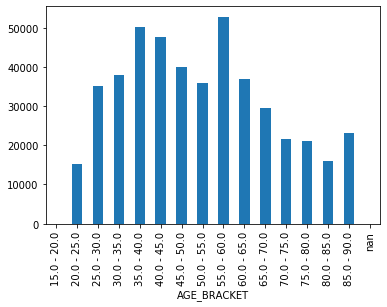

In [19]:
#Bar graph to show the total income changes by age bracket 
income_by_age_bracket.set_index('AGE_BRACKET')['PTOTVAL'].plot(kind='bar')

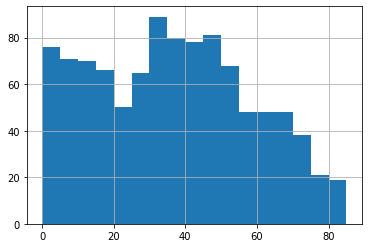

In [20]:
#Histogram to check how our population falls into their brackets
ppdf_new['A_AGE'].hist(bins=range(0,90,5))

In [21]:
#Exporting this dataframe so we can join it to our survey data
income_by_age_bracket.to_csv('../income_by_age_bracket.csv')